In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm
from scipy.stats import skew
import warnings

In [81]:
warnings.filterwarnings("ignore")

In [82]:
# Load dataset
df = pd.read_csv("tea_forex.csv", parse_dates=["Year-Month"], index_col="Year-Month")

In [83]:
df.head()

,High_Grown_Production_(Kg),Mid_Grown_Production_(Kg),Low_Grown_Production_(Kg),National_Production_(Kg),FEE_(Million_USD)
Year-Month,,,,,
2012-01-01,5361185.05,3652353.15,14348315.90,23361854.10,95.32
2012-02-01,5538399.31,3955745.75,13133213.00,22627358.06,100.17
2012-03-01,6385525.09,4625138.90,17929328.00,28939991.99,130.31
2012-04-01,7323011.00,5748401.20,16982493.50,30053905.70,110.41
2012-05-01,8726319.70,5898297.10,18086627.25,32711244.05,149.19


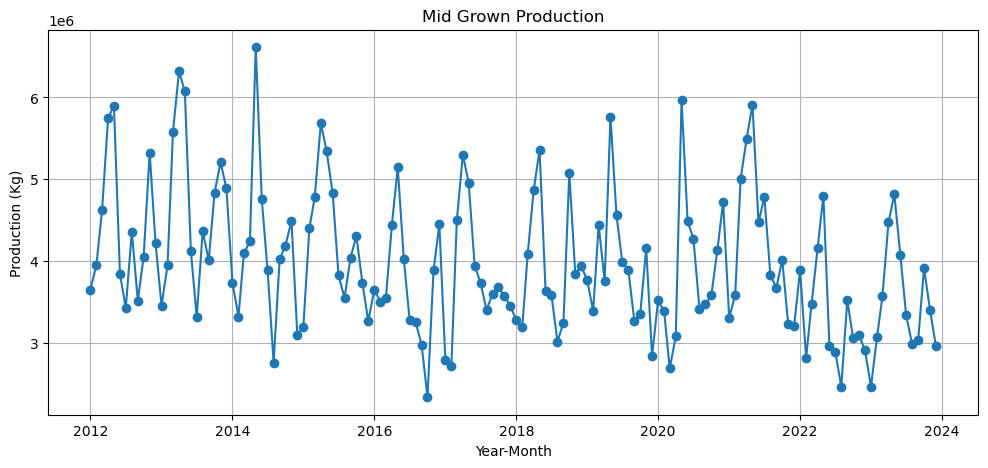

In [84]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df['Mid_Grown_Production_(Kg)'], marker='o', linestyle='-')
plt.title("Mid Grown Production")
plt.xlabel("Year-Month")
plt.ylabel("Production (Kg)")
plt.grid()
plt.show()

In [85]:
# Augmented Dickey-Fuller (ADF) Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Series is stationary.")
    else:
        print("Series is NOT stationary.")

In [86]:
print("ADF Test Before Differencing:")
adf_test(df["Mid_Grown_Production_(Kg)"])

ADF Test Before Differencing:
ADF Statistic: -2.0610033944105344
p-value: 0.2604815499214417
Critical Values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
Series is NOT stationary.


In [87]:
print("Skewness before Box-Cox:", skew(df["Mid_Grown_Production_(Kg)"]))
# If skewness is between -1 and 1, transformation isn’t needed.

Skewness before Box-Cox: 0.7298456571048381


In [88]:
# First Differencing
df["MGP_Diff"] = df["Mid_Grown_Production_(Kg)"].diff().dropna()

In [89]:
print("ADF Test After First Differencing:")
adf_test(df["MGP_Diff"].dropna())

ADF Test After First Differencing:
ADF Statistic: -8.883449251703773
p-value: 1.2991695674709157e-14
Critical Values: {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}
Series is stationary.


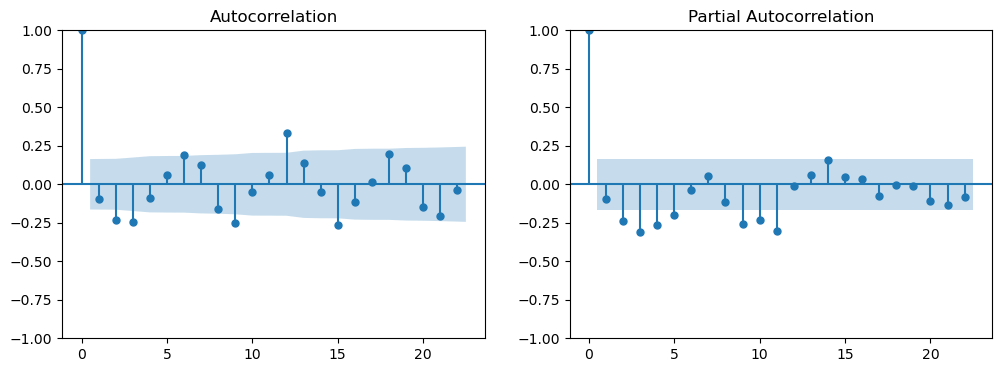

In [90]:
# ACF & PACF Plots to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df["MGP_Diff"].dropna(), ax=axes[0])
plot_pacf(df["MGP_Diff"].dropna(), ax=axes[1])
plt.show()

In [91]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df["Mid_Grown_Production_(Kg)"][:train_size], df["Mid_Grown_Production_(Kg)"][train_size:]

In [92]:
# Train ARIMA Model
p, d, q = 10, 1, 12
model = ARIMA(train, order=(p, d, q)).fit()

In [93]:
# Print Model Summary
print(model.summary())

                                   SARIMAX Results                                   
Dep. Variable:     Mid_Grown_Production_(Kg)   No. Observations:                  115
Model:                      ARIMA(10, 1, 12)   Log Likelihood               -1689.847
Date:                       Sun, 16 Mar 2025   AIC                           3425.694
Time:                               12:07:32   BIC                           3488.627
Sample:                           01-01-2012   HQIC                          3451.235
                                - 07-01-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3544      0.183     -1.938      0.053      -0.713       0.004
ar.L2         -0.6789      0.112     -6.073      0.000      -0.898      -0.

In [94]:
# Forecast future values
forecast = model.forecast(steps=len(test))

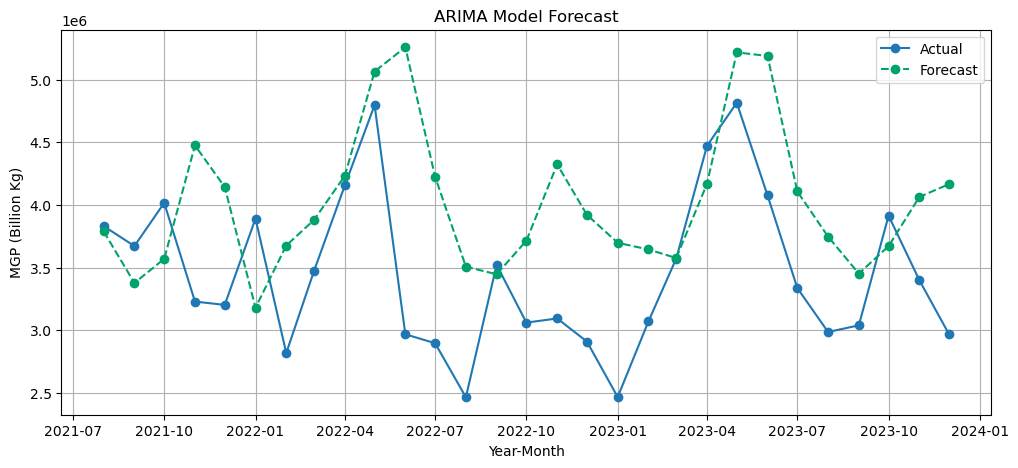

In [95]:
# Plot Actual vs. Forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index[train_size:], test, label="Actual", marker="o")
plt.plot(df.index[train_size:], forecast, label="Forecast", marker="o", color='#00A36C', linestyle="dashed")
plt.title("ARIMA Model Forecast")
plt.xlabel("Year-Month")
plt.ylabel("MGP (Billion Kg)")
plt.legend()
plt.grid()
plt.show()

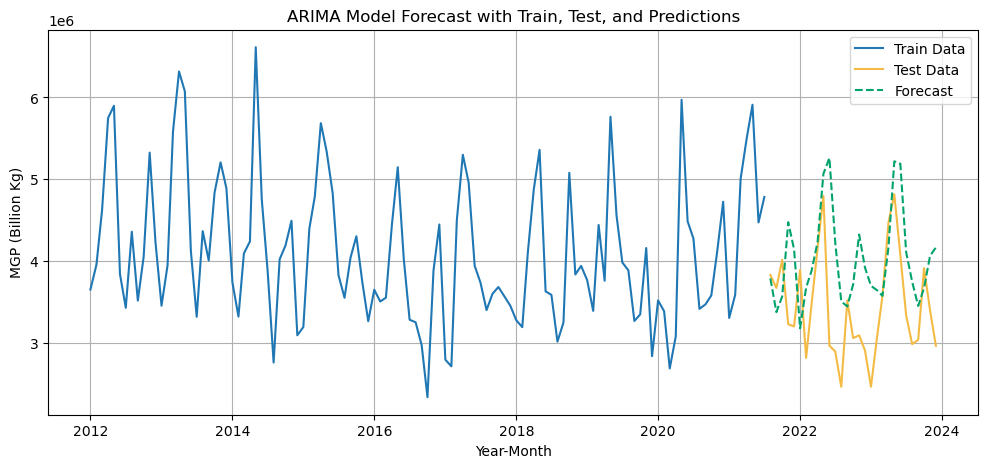

In [96]:
# Plot Actual vs. Forecast, including train and test data
plt.figure(figsize=(12, 5))
plt.plot(df.index[:train_size], train, label="Train Data")
plt.plot(df.index[train_size:], test, label="Test Data", color="#F4BB44")
plt.plot(df.index[train_size:], forecast, label="Forecast", color="#00A36C", linestyle="dashed")
plt.title("ARIMA Model Forecast with Train, Test, and Predictions")
plt.xlabel("Year-Month")
plt.ylabel("MGP (Billion Kg)")
plt.legend()
plt.grid()
plt.show()

In [97]:
# Model Evaluation
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.4f}")
print(f"Akaike Information Criterion (AIC): {model.aic:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 757069681717.9703
Root Mean Squared Error (RMSE): 870097.5128
Mean Absolute Percentage Error (MAPE): 22.7581
Akaike Information Criterion (AIC): 3425.6940


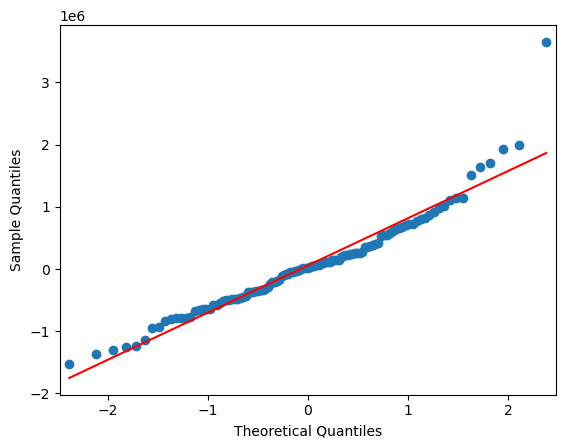

In [98]:
residuals = model.resid
sm.qqplot(residuals, line='s')
plt.show()
# If residuals deviate significantly from normality, more tuning is needed.